In [4]:
from MPC import *
from WindGym import WindFarmEnv
from utils import make_config
import numpy as np
from py_wake.examples.data.hornsrev1 import V80

In [5]:
USE_VARIABLE_HORIZON = True   # Use variable prediction horizon (paper's approach)
USE_TIME_SHIFTED = True      # Use time-shifted cost function (paper's best)
APPLY_YAW_PENALTY = True      # Use Equation 5 penalty for large yaw angles


In [6]:
config = make_config()

env = WindFarmEnv(
    turbine=V80(),  # e.g., IEA37/DTU10MW WT from PyWake
    x_pos=np.array([0, 400, 800]),  # x positions of the turbines
    y_pos=np.array([0, 0, 0]),      # y positions of the turbines
    config=config,
    turbtype="None",
    dt_env=60,
    dt_sim=10,
    yaw_step_sim=10*0.3,  # 10 sim step * 0.3 (yaw actuation time)
    yaw_init='Zeros',
    n_passthrough=30,
    reset_init=0,
    # wd_function=wd_func,
    # backend="pywake",         # <<< switch here
)

obs, info = env.reset(seed=42)

Steady state steps: 6.0


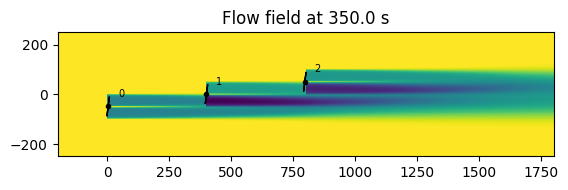

In [7]:
# Plot the inital farm here:
env.plot_farm()

In [8]:
env.wd, env.ws, env.ti, env.current_yaw

(277.1719583982277, 9.547912097111926, 0.05, array([0., 0., 0.]))

In [9]:
env.D

np.float64(80.0)

In [13]:
# Setup the MPC
D = env.D
x_pos = env.x_pos.copy()
y_pos = env.y_pos.copy()

mpc_model = WindFarmModel(x_pos, y_pos, D=D, cache_size=64000, 
                          wt=V80(),
                            cache_quant=0.25, wind_quant=0.25,
                            apply_yaw_penalty=APPLY_YAW_PENALTY)

current_yaws_orig = env.current_yaw.copy()
history = []

previous_opt_params = None
estimated_wd = env.wd
estimated_ws = env.ws
estimated_TI = env.ti

mpc_model.update_conditions(U_inf=estimated_ws, TI=estimated_TI, wd=estimated_wd)

current_yaws_sorted = current_yaws_orig[mpc_model.sorted_indices]

In [14]:
# Given the current situation, do one MPC step

optimized_params = optimize_farm_back2front(
    mpc_model, current_yaws_sorted, 
    r_gamma=0.3, # yaw rate (deg/s)
    t_AH=100.0,  # action horizon (s)
    dt_opt=10.0,  # optimization time step (s)
    T_opt=500.0,  # prediction horizon (s)
    maxfun=50,
    seed=42,
    initial_params=previous_opt_params
)

In [15]:
previous_opt_params = optimized_params.copy()
optimized_params

array([[0.70275648, 0.28099538],
       [0.69144015, 0.01768701],
       [0.50295207, 0.9760747 ]])

In [23]:
dt_mpc = 60 # MPC control interval (s)
t_action, trajectories, _ = run_farm_delay_loop_optimized(
    mpc_model, optimized_params, current_yaws_sorted, 
    r_gamma=0.3, t_AH=100.0, dt=10, T=500
)

next_yaws_sorted = np.array([traj[-1] for traj in trajectories])
next_yaws_orig = next_yaws_sorted[mpc_model.unsorted_indices]

print("next_yaws_orig: ", next_yaws_orig)

next_yaws_orig:  [12.16538876 11.48640901  0.17712392]


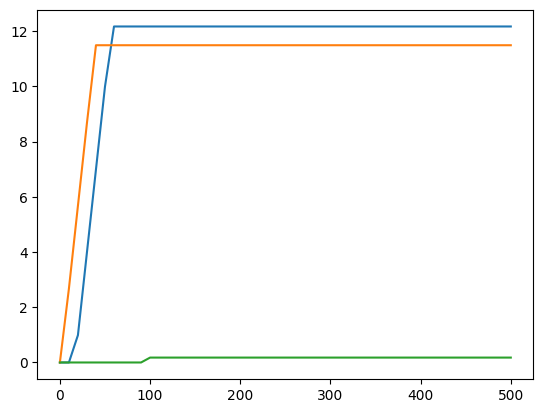

In [24]:
plt.plot(t_action, np.array(trajectories).T)

In [18]:
# The action should then be:
action = (next_yaws_orig - env.yaw_min) / (env.yaw_max - env.yaw_min) * 2 - 1


In [19]:
# Do the env step:
obs, reward, terminated, truncated,  info = env.step(action)

In [27]:
info["powers"].sum(axis=1)

array([2442238. , 2421395. , 2386720.2, 2342447.5, 2525779. , 2860761.8],
      dtype=float32)

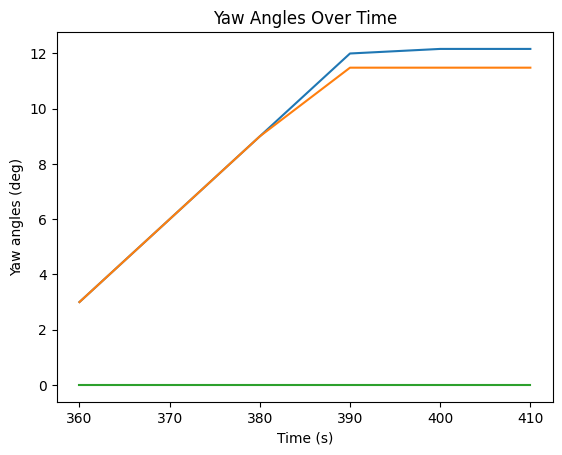

In [21]:
plt.plot(info["time_array"], info["yaws"])
plt.xlabel("Time (s)")
plt.ylabel("Yaw angles (deg)")
plt.title("Yaw Angles Over Time")
plt.show()

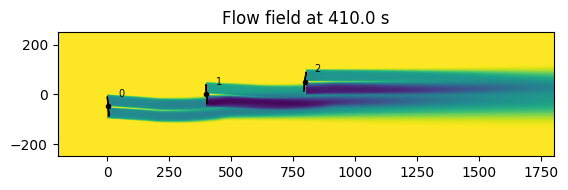

In [22]:
# The farm is now:
env.plot_farm()